In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg
from sympy import *
from sympy.physics.quantum.dagger import Dagger

## 4. Experimental results and derivations
The paper \[topic2\] describes three experiments A, B and C. Here we will derive the theoretical expressions they use for fitting their data using the SymPy package.

In [2]:
t,p,ta,pa,tb,pb = symbols('theta varphi theta_a varphi_a theta_b varphi_b',real=True)
A_HWP = Matrix([[-cos(ta/2),0,-sin(ta/2),0],[0,-cos(ta/2),0,-sin(ta/2)],[-sin(ta/2),0,cos(ta/2),0],
              [0,-sin(ta/2),0,cos(ta/2)]])
A_SLM = Matrix([[cos(pa/2),I*sin(pa/2),0,0],[I*sin(pa/2),cos(pa/2),0,0],[0,0,cos(pa/2),I*sin(pa/2)],
             [0,0,I*sin(pa/2),cos(pa/2)]])
A_PSSLM = Matrix([[cos(pa/2),I*sin(pa/2),0,0],[I*sin(pa/2),cos(pa/2),0,0],[0,0,1,0],
             [0,0,0,1]]) 

def trace_G(G): #A trace function for just 4x4 G matrices
    return simplify(G[0,0] + G[1,1] + G[2,2] + G[3,3])
def corr_prob(G): #Returns the value I_He - I_Ho - I_Ve +I_Vo from given G matrix
    return simplify(G[0,0] - G[1,1] - G[2,2] + G[3,3])

def par_tr_G_pol(G): #returns the partial trace of G for giving G_pol
    return simplify(Matrix([[G[0,0]+G[1,1],G[0,2]+G[1,3]],[G[2,0]+G[3,1],G[2,2]+G[3,3]]]))

def par_tr_G_par(G): #returns the partial trace of G for giving G_par
    return Matrix([[G[0,0]+G[2,2],G[0,1]+G[2,3]],[G[1,0]+G[3,2],G[1,1]+G[3,3]]])

def app_coh(G): #Returns apparent degree of coherence for a 2x2 G matrix
    return simplify(sqrt(1-4*simplify(Determinant(G))/(simplify(Trace(G))**2)))

def norm_grad(B,syms):
    c = 0
    for i in syms:
        c += simplify(B.diff(i)**2)
    return simplify(c)

### 4.1 Experiment A
Here the field is competely coherent and we start with the Jones vector in state $\mathbf{J} = (1/\sqrt{2})[\cos(\varphi/2)\text{ }\iota\sin(\varphi/2)\text{ 1 0}]^T$ which is reached by applying the PS-SLM on the input state of $\mathbf{J}_{in} = (1/\sqrt{2})[\text{1 0 1 0}]^T$. On this we then apply the rotation of basis by $\theta_a$ for polarization and of $\varphi_a$ for parity and then conduct measurements of each component. Based on our previous definitions we now derive the correlation function for this experiment.

In [3]:
J = sqrt(1/2)*Matrix([cos(p/2),I*sin(p/2),1,0])
G_A = trigsimp(conjugate(J)*J.T)
G_A #The input beam G matrix before the transformations

Matrix([
[0.5*cos(varphi/2)**2,   0.25*I*sin(varphi),    0.5*cos(varphi/2), 0],
[ -0.25*I*sin(varphi), 0.5*sin(varphi/2)**2, -0.5*I*sin(varphi/2), 0],
[   0.5*cos(varphi/2),  0.5*I*sin(varphi/2),                  0.5, 0],
[                   0,                    0,                    0, 0]])

In [4]:
G_pol_A = par_tr_G_pol(G_A)
G_pol_A

Matrix([
[              0.5, 0.5*cos(varphi/2)],
[0.5*cos(varphi/2),               0.5]])

In [5]:
app_coh(G_pol_A)# Prints D_pol

1.0*Abs(cos(varphi/2))

In [6]:
G_par_A = par_tr_G_par(G_A)
G_par_A

Matrix([
[0.5*cos(varphi/2)**2 + 0.5,   0.25*I*sin(varphi)],
[       -0.25*I*sin(varphi), 0.5*sin(varphi/2)**2]])

In [7]:
app_coh(G_par_A)# Prints D_par

0.707106781186548*sqrt(cos(varphi) + 1)

In [8]:
G_out_A = conjugate(A_SLM)*conjugate(A_HWP)*G_A*A_HWP.T*A_SLM.T #Transformed matrix
C_ta_pa_A = trigsimp(corr_prob(G_out_A)/trace_G(G_out_A))
C_ta_pa_A

1.0*sin(theta_a)*cos(varphi/2 + varphi_a) - 0.5*cos(theta_a)*cos(varphi_a) + 0.5*cos(theta_a)*cos(varphi + varphi_a)

In [9]:
expected = sin(p/2)*sin(ta-pa-p/2) - (1-sin(p/2))*cos(pa+p/2)*sin(ta)
trigsimp(expected-C_ta_pa_A)#Not matching :(

-(1 - sin(varphi/2))*sin(theta_a)*cos(varphi/2 + varphi_a) - 1.0*sin(theta_a)*cos(varphi/2 + varphi_a) - sin(varphi/2)*sin(-theta_a + varphi/2 + varphi_a) + 0.5*cos(theta_a)*cos(varphi_a) - 0.5*cos(theta_a)*cos(varphi + varphi_a)

(0.0, 6.283185307179586, 0.0, 6.283185307179586)

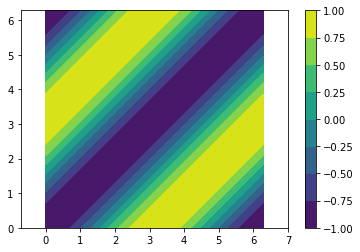

In [38]:
f = lambdify((t,p,ta,pa),trigsimp(expected), "numpy")
ta_range = np.linspace(0,2*np.pi,1000)
pa_range = np.linspace(0,2*np.pi,1000)
phi_fixed = np.pi
X, Y = np.meshgrid(ta_range, pa_range)
def ftemp(ta_val,pa_val):
    return f(0,phi_fixed,ta_val,pa_val)
Z = ftemp(X,Y)
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp) # Add a colorbar to a plot
plt.xlim(0,2*np.pi)
plt.ylim(0,2*np.pi)
ax.axis('equal')

In [11]:
B_A = abs(simplify(C_ta_pa_A + C_ta_pa_A.xreplace({ta:tb}) + C_ta_pa_A.xreplace({pa:pb}) - C_ta_pa_A.xreplace({ta:tb,pa:pb})))
B_A

Abs(1.0*sin(theta_a)*cos(varphi/2 + varphi_a) + 1.0*sin(theta_a)*cos(varphi/2 + varphi_b) + 1.0*sin(theta_b)*cos(varphi/2 + varphi_a) - 1.0*sin(theta_b)*cos(varphi/2 + varphi_b) - 0.5*cos(theta_a)*cos(varphi_a) - 0.5*cos(theta_a)*cos(varphi_b) + 0.5*cos(theta_a)*cos(varphi + varphi_a) + 0.5*cos(theta_a)*cos(varphi + varphi_b) - 0.5*cos(theta_b)*cos(varphi_a) + 0.5*cos(theta_b)*cos(varphi_b) + 0.5*cos(theta_b)*cos(varphi + varphi_a) - 0.5*cos(theta_b)*cos(varphi + varphi_b))

In [12]:
B_A.diff(ta)

(0.5*sin(theta_a)*cos(varphi_a) + 0.5*sin(theta_a)*cos(varphi_b) - 0.5*sin(theta_a)*cos(varphi + varphi_a) - 0.5*sin(theta_a)*cos(varphi + varphi_b) + 1.0*cos(theta_a)*cos(varphi/2 + varphi_a) + 1.0*cos(theta_a)*cos(varphi/2 + varphi_b))*sign(1.0*sin(theta_a)*cos(varphi/2 + varphi_a) + 1.0*sin(theta_a)*cos(varphi/2 + varphi_b) + 1.0*sin(theta_b)*cos(varphi/2 + varphi_a) - 1.0*sin(theta_b)*cos(varphi/2 + varphi_b) - 0.5*cos(theta_a)*cos(varphi_a) - 0.5*cos(theta_a)*cos(varphi_b) + 0.5*cos(theta_a)*cos(varphi + varphi_a) + 0.5*cos(theta_a)*cos(varphi + varphi_b) - 0.5*cos(theta_b)*cos(varphi_a) + 0.5*cos(theta_b)*cos(varphi_b) + 0.5*cos(theta_b)*cos(varphi + varphi_a) - 0.5*cos(theta_b)*cos(varphi + varphi_b))

In [13]:
B_A.diff(tb)

(0.5*sin(theta_b)*cos(varphi_a) - 0.5*sin(theta_b)*cos(varphi_b) - 0.5*sin(theta_b)*cos(varphi + varphi_a) + 0.5*sin(theta_b)*cos(varphi + varphi_b) + 1.0*cos(theta_b)*cos(varphi/2 + varphi_a) - 1.0*cos(theta_b)*cos(varphi/2 + varphi_b))*sign(1.0*sin(theta_a)*cos(varphi/2 + varphi_a) + 1.0*sin(theta_a)*cos(varphi/2 + varphi_b) + 1.0*sin(theta_b)*cos(varphi/2 + varphi_a) - 1.0*sin(theta_b)*cos(varphi/2 + varphi_b) - 0.5*cos(theta_a)*cos(varphi_a) - 0.5*cos(theta_a)*cos(varphi_b) + 0.5*cos(theta_a)*cos(varphi + varphi_a) + 0.5*cos(theta_a)*cos(varphi + varphi_b) - 0.5*cos(theta_b)*cos(varphi_a) + 0.5*cos(theta_b)*cos(varphi_b) + 0.5*cos(theta_b)*cos(varphi + varphi_a) - 0.5*cos(theta_b)*cos(varphi + varphi_b))

In [14]:
B_A.diff(pa)

(-1.0*sin(theta_a)*sin(varphi/2 + varphi_a) - 1.0*sin(theta_b)*sin(varphi/2 + varphi_a) + 0.5*sin(varphi_a)*cos(theta_a) + 0.5*sin(varphi_a)*cos(theta_b) - 0.5*sin(varphi + varphi_a)*cos(theta_a) - 0.5*sin(varphi + varphi_a)*cos(theta_b))*sign(1.0*sin(theta_a)*cos(varphi/2 + varphi_a) + 1.0*sin(theta_a)*cos(varphi/2 + varphi_b) + 1.0*sin(theta_b)*cos(varphi/2 + varphi_a) - 1.0*sin(theta_b)*cos(varphi/2 + varphi_b) - 0.5*cos(theta_a)*cos(varphi_a) - 0.5*cos(theta_a)*cos(varphi_b) + 0.5*cos(theta_a)*cos(varphi + varphi_a) + 0.5*cos(theta_a)*cos(varphi + varphi_b) - 0.5*cos(theta_b)*cos(varphi_a) + 0.5*cos(theta_b)*cos(varphi_b) + 0.5*cos(theta_b)*cos(varphi + varphi_a) - 0.5*cos(theta_b)*cos(varphi + varphi_b))

In [15]:
B_A.diff(pb)

(-1.0*sin(theta_a)*sin(varphi/2 + varphi_b) + 1.0*sin(theta_b)*sin(varphi/2 + varphi_b) + 0.5*sin(varphi_b)*cos(theta_a) - 0.5*sin(varphi_b)*cos(theta_b) - 0.5*sin(varphi + varphi_b)*cos(theta_a) + 0.5*sin(varphi + varphi_b)*cos(theta_b))*sign(1.0*sin(theta_a)*cos(varphi/2 + varphi_a) + 1.0*sin(theta_a)*cos(varphi/2 + varphi_b) + 1.0*sin(theta_b)*cos(varphi/2 + varphi_a) - 1.0*sin(theta_b)*cos(varphi/2 + varphi_b) - 0.5*cos(theta_a)*cos(varphi_a) - 0.5*cos(theta_a)*cos(varphi_b) + 0.5*cos(theta_a)*cos(varphi + varphi_a) + 0.5*cos(theta_a)*cos(varphi + varphi_b) - 0.5*cos(theta_b)*cos(varphi_a) + 0.5*cos(theta_b)*cos(varphi_b) + 0.5*cos(theta_b)*cos(varphi + varphi_a) - 0.5*cos(theta_b)*cos(varphi + varphi_b))

In [16]:
#Put graphs and all here

### 4.2 Experiment B
Here starting with the same $\mathbf{J}_{in}$ the polarization is scrambled using a variable polarization rotator which does not affect the spatial DoF so we have $D_\text{pol} = 0$ and $D_\text{par} = 1$. Now this beam is sent through a PS-SLM which would couple the DoFs. We now go on to derive the correlation function for this

In [17]:
G_B = (1/2)*Matrix([[cos(p/2)**2, I*cos(p/2)*sin(p/2), 0, 0],[-I*cos(p/2)*sin(p/2), sin(p/2)**2, 0,0],
            [0,0,1,0],[0,0,0,0]])
G_B #The input beam G matrix before the transformations

Matrix([
[              0.5*cos(varphi/2)**2, 0.5*I*sin(varphi/2)*cos(varphi/2),   0, 0],
[-0.5*I*sin(varphi/2)*cos(varphi/2),              0.5*sin(varphi/2)**2,   0, 0],
[                                 0,                                 0, 0.5, 0],
[                                 0,                                 0,   0, 0]])

In [18]:
G_pol_B = par_tr_G_pol(G_B)
G_pol_B

Matrix([
[0.5,   0],
[  0, 0.5]])

In [19]:
app_coh(G_pol_B)# Prints D_pol

0

In [20]:
G_par_B = par_tr_G_par(G_B)
G_par_B

Matrix([
[        0.5*cos(varphi/2)**2 + 0.5, 0.5*I*sin(varphi/2)*cos(varphi/2)],
[-0.5*I*sin(varphi/2)*cos(varphi/2),              0.5*sin(varphi/2)**2]])

In [21]:
app_coh(G_par_B)# Prints D_par

0.707106781186548*sqrt(cos(varphi) + 1)

In [22]:
G_out_B = conjugate(A_SLM)*conjugate(A_HWP)*G_B*A_HWP.T*A_SLM.T #Transformed matrix
C_ta_pa_B = trigsimp(corr_prob(G_out_B)/trace_G(G_out_B))
C_ta_pa_B #Exactly matches expression in paper

0.5*(-cos(varphi_a) + cos(varphi + varphi_a))*cos(theta_a)

In [23]:
B_B = abs(simplify(C_ta_pa_B + C_ta_pa_B.xreplace({ta:tb}) + C_ta_pa_B.xreplace({pa:pb}) - C_ta_pa_B.xreplace({ta:tb,pa:pb})))
B_B

Abs(0.5*(cos(varphi_a) - cos(varphi + varphi_a))*cos(theta_a) + 0.5*(cos(varphi_a) - cos(varphi + varphi_a))*cos(theta_b) + 0.5*(cos(varphi_b) - cos(varphi + varphi_b))*cos(theta_a) - 0.5*(cos(varphi_b) - cos(varphi + varphi_b))*cos(theta_b))

In [24]:
simplify(B_B.diff(ta))

-0.5*(cos(varphi_a) + cos(varphi_b) - cos(varphi + varphi_a) - cos(varphi + varphi_b))*sin(theta_a)*sign((cos(varphi_a) - cos(varphi + varphi_a))*cos(theta_a) + (cos(varphi_a) - cos(varphi + varphi_a))*cos(theta_b) + (cos(varphi_b) - cos(varphi + varphi_b))*cos(theta_a) - (cos(varphi_b) - cos(varphi + varphi_b))*cos(theta_b))

In [25]:
simplify(B_B.diff(tb))

-0.5*(cos(varphi_a) - cos(varphi_b) - cos(varphi + varphi_a) + cos(varphi + varphi_b))*sin(theta_b)*sign((cos(varphi_a) - cos(varphi + varphi_a))*cos(theta_a) + (cos(varphi_a) - cos(varphi + varphi_a))*cos(theta_b) + (cos(varphi_b) - cos(varphi + varphi_b))*cos(theta_a) - (cos(varphi_b) - cos(varphi + varphi_b))*cos(theta_b))

In [26]:
simplify(B_B.diff(pa))

-0.5*(sin(varphi_a) - sin(varphi + varphi_a))*(cos(theta_a) + cos(theta_b))*sign((cos(varphi_a) - cos(varphi + varphi_a))*cos(theta_a) + (cos(varphi_a) - cos(varphi + varphi_a))*cos(theta_b) + (cos(varphi_b) - cos(varphi + varphi_b))*cos(theta_a) - (cos(varphi_b) - cos(varphi + varphi_b))*cos(theta_b))

In [27]:
simplify(B_B.diff(pb))

-0.5*(sin(varphi_b) - sin(varphi + varphi_b))*(cos(theta_a) - cos(theta_b))*sign((cos(varphi_a) - cos(varphi + varphi_a))*cos(theta_a) + (cos(varphi_a) - cos(varphi + varphi_a))*cos(theta_b) + (cos(varphi_b) - cos(varphi + varphi_b))*cos(theta_a) - (cos(varphi_b) - cos(varphi + varphi_b))*cos(theta_b))

### 4.3 Experiment C
In this experiment we again start with the same $\mathbf{J}_{in}$ and an interaction is considered that makes it have a random coupling. It has a probability $P$ to couple polarization and parity and $1-P$ to not achieved by randomly toggling between two phase distributions of the PS-SLM, one with $\pi/2\text{sgn}(x)$ phase and another with zero phase where $P$ is the fraction of time that the PS-SLM displays the first phase pattern. From this we go on to derive it's correlation function.

In [28]:
P = symbols('P',real=True)
J_ent = (1/sqrt(2))*Matrix([0, I, 1, 0])#Entagled state
J_in = (1/sqrt(2))*Matrix([1, 0, 1, 0])#Input state
G_C = P*conjugate(J_ent)*J_ent.T + (1-P)*conjugate(J_in)*J_in.T
G_C

Matrix([
[1/2 - P/2,     0, 1/2 - P/2, 0],
[        0,   P/2,    -I*P/2, 0],
[1/2 - P/2, I*P/2,       1/2, 0],
[        0,     0,         0, 0]])

In [29]:
G_pol_C = par_tr_G_pol(G_C)
G_pol_C

Matrix([
[      1/2, 1/2 - P/2],
[1/2 - P/2,       1/2]])

In [30]:
app_coh(G_pol_C)# Prints D_pol

Abs(P - 1)

In [31]:
G_par_C = par_tr_G_par(G_C)
G_par_C

Matrix([
[1 - P/2,   0],
[      0, P/2]])

In [32]:
app_coh(G_par_C)# Prints D_pol

sqrt(-P*(2 - P) + 1)

In [33]:
G_out_C = conjugate(A_SLM)*conjugate(A_HWP)*G_C*A_HWP.T*A_SLM.T #Transformed matrix
C_ta_pa_C = trigsimp(corr_prob(G_out_C)/trace_G(G_out_C))
C_ta_pa_C

-sqrt(2)*P*sin(theta_a)*sin(varphi_a + pi/4) - P*cos(theta_a)*cos(varphi_a) + sin(theta_a)*cos(varphi_a)

In [34]:
expectedc = (1-P)*sin(ta)*cos(pa) - P*cos(ta-pa)
trigsimp(C_ta_pa_C-expectedc)#Exactly matches

0

In [36]:
B_C = abs(simplify(C_ta_pa_C + C_ta_pa_C.xreplace({ta:tb}) + C_ta_pa_C.xreplace({pa:pb}) - C_ta_pa_C.xreplace({ta:tb,pa:pb})))
B_C

Abs(sqrt(2)*P*sin(theta_a)*sin(varphi_a + pi/4) + sqrt(2)*P*sin(theta_a)*sin(varphi_b + pi/4) + sqrt(2)*P*sin(theta_b)*sin(varphi_a + pi/4) - sqrt(2)*P*sin(theta_b)*sin(varphi_b + pi/4) + P*cos(theta_a)*cos(varphi_a) + P*cos(theta_a)*cos(varphi_b) + P*cos(theta_b)*cos(varphi_a) - P*cos(theta_b)*cos(varphi_b) - sin(theta_a)*cos(varphi_a) - sin(theta_a)*cos(varphi_b) - sin(theta_b)*cos(varphi_a) + sin(theta_b)*cos(varphi_b))